In [13]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf

In [14]:
replay_memory = np.load('../replay_memory_50.npy', allow_pickle=True)
print("replay experience shape:   ", np.shape(replay_memory))
replay_memory = np.ndarray.tolist(replay_memory)
print("replay experience example: ", replay_memory[2])

replay experience shape:    (5052, 8)
replay experience example:  [353.0, 319.0, 351.0, 321.0, 3.0, -8.94427190999916, 347.0, 329.0]


In [15]:
from DQ_Learning import environment, GetMinibatch
from keras.callbacks import ReduceLROnPlateau
# ReduceLR = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 4, verbose=1, mode = 'min')

In [16]:
class DQNet(tf.keras.Model):
    def __init__(self):
        global servo_0_target
        global servo_1_target
        super().__init__()
        self.dense1 = tf.keras.layers.Dense(6, activation = tf.nn.tanh)
        self.dense2 = tf.keras.layers.Dense(4, activation = tf.nn.tanh)
        self.dense3 = tf.keras.layers.Dense(4, activation = tf.nn.tanh)
        self.dense4 = tf.keras.layers.Dense(1)
        
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.bn4 = tf.keras.layers.BatchNormalization()

    def call(self, inputs):
        
        x = self.bn1(inputs)
        
        x = self.dense1(x)
        x = self.bn2(x)
        
#         x = self.dense2(x)
#         x = self.bn3(x)
        
        x = self.dense3(x)
        x = self.bn4(x)
        
        x = self.dense4(x)
        output = x
        return output
    
    def get_best(self, state_current, target_pos, get_action, is_training):
        global servo_0_target
        global servo_1_target
        action = 5
        action_0 = 0.1 * (-1 + (action - 1)//3)
        action_1 = 0.1 * (-1 + (action - 1) %3)
        inputs = tf.constant([[state_current[0], state_current[1], 
                               target_pos[0], target_pos[1], action_0, action_1]])
        value = self.call(inputs = inputs).numpy()[0][0]

        if is_training:
            for i in range(9):
                # i varies from 0 to 7, action of i+2 varies from 2 to 9
                action_0 = 0.1 * (-1 + (i + 1 - 1)//3)
                action_1 = 0.1 * (-1 + (i + 1 - 1) %3)
                inputs = tf.constant([[state_current[0], state_current[1], target_pos[0], target_pos[1], action_0, action_1]])
                value_new = self.call(inputs = inputs).numpy()[0][0]
                if value <= value_new:
                    value = value_new
                    action = i + 1
            return action if get_action else value

In [17]:
model = DQNet()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = tf.keras.losses.MeanSquaredError(), metrics = 'mae')

model_ = DQNet()
model_.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = tf.keras.losses.MeanSquaredError(), metrics = 'mae')

mae_liste  = []
mae_liste_ = []
loss_liste = []

In [20]:
for step in range(50):
    x_train, y_train = [], []
    minibatch = GetMinibatch(1000, replay_memory)
    for (i, mini) in enumerate(minibatch):
        if mini[5] >= -10:
            y_train.append(mini[5])
        else:
            value_ = model_.get_best([mini[6], mini[7]], [mini[2], mini[3]], get_action = False, is_training = True)
            y_train.append(mini[5] + 0.9*value_)
            
        action_0 = 0.1 * (-1 + (mini[4] - 1)//3)
        action_1 = 0.1 * (-1 + (mini[4] - 1) %3)
        x_train.append([mini[0], mini[1], mini[2], mini[3], action_0, action_1])
        
    history = model.fit(np.array(x_train), np.array(y_train), batch_size = 64, epochs = 100)
    mae_liste.append(history.history['mae'])
    mae_liste_.append(history.history['mae']/np.mean(y_train))
    loss_liste.append(history.history['loss']/(np.mean(y_train)**2))
    # callbacks = [ReduceLR]
    model.save_weights("./predict_model_monday")
    
    print(step)
    if (step%4 == 3 and step <= 8):
        print("______________________target network update______________________")
        model_ = DQNet()
        model_.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = tf.keras.losses.MeanSquaredError(), metrics = 'mae')
        model_.load_weights("./predict_model_monday")
    if (step%2 == 1 and step >= 9):
        print("______________________target network update______________________")
        model_ = DQNet()
        model_.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = tf.keras.losses.MeanSquaredError(), metrics = 'mae')
        model_.load_weights("./predict_model_monday")

Epoch 1/100
16/16 [==============================] - 1s 10ms/step - loss: 28083.1648 - mae: 141.4871
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 29402.6334 - mae: 145.8159
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 29262.9553 - mae: 144.8597
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 28658.7490 - mae: 143.8784
Epoch 5/100
16/16 [==============================] - 0s 12ms/step - loss: 28548.8051 - mae: 142.3425
Epoch 6/100
16/16 [==============================] - 0s 12ms/step - loss: 29644.7858 - mae: 146.3494
Epoch 7/100
16/16 [==============================] - 0s 11ms/step - loss: 27452.7381 - mae: 139.5304
Epoch 8/100
16/16 [==============================] - 0s 11ms/step - loss: 28912.2978 - mae: 144.7351
Epoch 9/100
16/16 [==============================] - 0s 11ms/step - loss: 28710.9380 - mae: 143.9152
Epoch 10/100
16/16 [==============================] - 0s 11ms/step - loss: 28188.6452 - mae

16/16 [==============================] - 0s 11ms/step - loss: 20808.0319 - mae: 126.9256
Epoch 74/100
16/16 [==============================] - 0s 11ms/step - loss: 21425.5527 - mae: 129.3595
Epoch 75/100
16/16 [==============================] - 0s 11ms/step - loss: 20557.1955 - mae: 126.1626
Epoch 76/100
16/16 [==============================] - 0s 10ms/step - loss: 22176.3495 - mae: 131.2349
Epoch 77/100
16/16 [==============================] - 0s 10ms/step - loss: 21305.3038 - mae: 128.9115
Epoch 78/100
16/16 [==============================] - 0s 11ms/step - loss: 20494.2292 - mae: 126.9241
Epoch 79/100
16/16 [==============================] - 0s 10ms/step - loss: 19356.7147 - mae: 122.7413
Epoch 80/100
16/16 [==============================] - 0s 10ms/step - loss: 21332.8611 - mae: 128.9452
Epoch 81/100
16/16 [==============================] - 0s 10ms/step - loss: 20184.0988 - mae: 125.6995
Epoch 82/100
16/16 [==============================] - 0s 11ms/step - loss: 19936.5506 - mae: 12

16/16 [==============================] - 0s 11ms/step - loss: 10006.7734 - mae: 93.2558
Epoch 54/100
16/16 [==============================] - 0s 11ms/step - loss: 9883.0469 - mae: 92.7725
Epoch 55/100
16/16 [==============================] - 0s 10ms/step - loss: 9732.5771 - mae: 92.2854
Epoch 56/100
16/16 [==============================] - 0s 11ms/step - loss: 9642.2051 - mae: 91.8032
Epoch 57/100
16/16 [==============================] - 0s 11ms/step - loss: 9612.2236 - mae: 91.3161
Epoch 58/100
16/16 [==============================] - 0s 11ms/step - loss: 9462.7266 - mae: 90.8357
Epoch 59/100
16/16 [==============================] - 0s 11ms/step - loss: 9460.7734 - mae: 90.3468
Epoch 60/100
16/16 [==============================] - 0s 10ms/step - loss: 9241.7656 - mae: 89.8531
Epoch 61/100
16/16 [==============================] - 0s 10ms/step - loss: 9230.4150 - mae: 89.3948
Epoch 62/100
16/16 [==============================] - 0s 10ms/step - loss: 9010.8486 - mae: 88.8898
Epoch 63/100

16/16 [==============================] - 0s 10ms/step - loss: 3219.2954 - mae: 51.2930
Epoch 36/100
16/16 [==============================] - 0s 9ms/step - loss: 3123.0823 - mae: 50.8724
Epoch 37/100
16/16 [==============================] - 0s 11ms/step - loss: 3061.5029 - mae: 49.7369
Epoch 38/100
16/16 [==============================] - 0s 10ms/step - loss: 3089.9519 - mae: 49.6709
Epoch 39/100
16/16 [==============================] - 0s 10ms/step - loss: 3013.6785 - mae: 49.2453
Epoch 40/100
16/16 [==============================] - 0s 10ms/step - loss: 2863.2114 - mae: 48.3697
Epoch 41/100
16/16 [==============================] - 0s 10ms/step - loss: 2858.0706 - mae: 48.2418
Epoch 42/100
16/16 [==============================] - 0s 10ms/step - loss: 2874.4729 - mae: 47.8974
Epoch 43/100
16/16 [==============================] - 0s 11ms/step - loss: 2781.1943 - mae: 47.6440
Epoch 44/100
16/16 [==============================] - 0s 10ms/step - loss: 2586.6604 - mae: 46.4532
Epoch 45/100
1

16/16 [==============================] - 0s 16ms/step - loss: 1125.9084 - mae: 27.0286
Epoch 17/100
16/16 [==============================] - 0s 15ms/step - loss: 1041.8790 - mae: 26.2293
Epoch 18/100
16/16 [==============================] - 0s 17ms/step - loss: 1238.3975 - mae: 28.4033
Epoch 19/100
16/16 [==============================] - 0s 13ms/step - loss: 1122.7686 - mae: 27.4385
Epoch 20/100
16/16 [==============================] - 0s 13ms/step - loss: 1019.9429 - mae: 26.3735
Epoch 21/100
16/16 [==============================] - 0s 12ms/step - loss: 1016.1902 - mae: 25.7062
Epoch 22/100
16/16 [==============================] - 0s 12ms/step - loss: 1076.3029 - mae: 25.9540
Epoch 23/100
16/16 [==============================] - 0s 12ms/step - loss: 949.7321 - mae: 24.5340
Epoch 24/100
16/16 [==============================] - 0s 11ms/step - loss: 943.1600 - mae: 24.6542
Epoch 25/100
16/16 [==============================] - 0s 11ms/step - loss: 1127.6863 - mae: 26.2752
Epoch 26/100
16

16/16 [==============================] - 0s 13ms/step - loss: 539.1511 - mae: 18.7683
Epoch 99/100
16/16 [==============================] - 0s 12ms/step - loss: 592.1976 - mae: 18.7778
Epoch 100/100
16/16 [==============================] - 0s 11ms/step - loss: 623.8726 - mae: 19.9568
3
______________________target network update______________________
Epoch 1/100
16/16 [==============================] - 0s 15ms/step - loss: 20909.3398 - mae: 118.9179
Epoch 2/100
16/16 [==============================] - 0s 15ms/step - loss: 18764.9199 - mae: 115.6026
Epoch 3/100
16/16 [==============================] - 0s 15ms/step - loss: 17261.5840 - mae: 112.6264
Epoch 4/100
16/16 [==============================] - 0s 13ms/step - loss: 15860.2617 - mae: 109.8023
Epoch 5/100
16/16 [==============================] - 0s 14ms/step - loss: 15484.4580 - mae: 107.1974
Epoch 6/100
16/16 [==============================] - 0s 12ms/step - loss: 14997.5889 - mae: 105.3766
Epoch 7/100
16/16 [======================

16/16 [==============================] - 0s 12ms/step - loss: 3056.6675 - mae: 45.4217
Epoch 80/100
16/16 [==============================] - 0s 11ms/step - loss: 2817.0173 - mae: 43.0617
Epoch 81/100
16/16 [==============================] - 0s 12ms/step - loss: 2752.6694 - mae: 42.3383
Epoch 82/100
16/16 [==============================] - 0s 11ms/step - loss: 2588.3008 - mae: 40.7905
Epoch 83/100
16/16 [==============================] - 0s 11ms/step - loss: 3290.8833 - mae: 46.7517
Epoch 84/100
16/16 [==============================] - 0s 12ms/step - loss: 2630.8115 - mae: 40.9010
Epoch 85/100
16/16 [==============================] - 0s 12ms/step - loss: 3102.1135 - mae: 44.4329
Epoch 86/100
16/16 [==============================] - 0s 11ms/step - loss: 2656.8357 - mae: 40.8503
Epoch 87/100
16/16 [==============================] - 0s 13ms/step - loss: 2781.0037 - mae: 42.9957
Epoch 88/100
16/16 [==============================] - 0s 12ms/step - loss: 2891.5066 - mae: 43.7309
Epoch 89/100


16/16 [==============================] - 0s 11ms/step - loss: 1834.5685 - mae: 33.6778
Epoch 62/100
16/16 [==============================] - 0s 13ms/step - loss: 1796.8837 - mae: 32.7162
Epoch 63/100
16/16 [==============================] - 0s 12ms/step - loss: 1915.8945 - mae: 33.7863
Epoch 64/100
16/16 [==============================] - 0s 13ms/step - loss: 1957.8455 - mae: 34.5812
Epoch 65/100
16/16 [==============================] - 0s 12ms/step - loss: 1619.8903 - mae: 31.0450
Epoch 66/100
16/16 [==============================] - 0s 12ms/step - loss: 1712.0193 - mae: 32.5963
Epoch 67/100
16/16 [==============================] - 0s 12ms/step - loss: 1303.9803 - mae: 28.5203
Epoch 68/100
16/16 [==============================] - 0s 12ms/step - loss: 1905.7380 - mae: 32.7437
Epoch 69/100
16/16 [==============================] - 0s 13ms/step - loss: 1882.7465 - mae: 34.4716
Epoch 70/100
16/16 [==============================] - 0s 11ms/step - loss: 2216.6770 - mae: 36.6185
Epoch 71/100


16/16 [==============================] - 0s 12ms/step - loss: 1828.6102 - mae: 32.5264
Epoch 44/100
16/16 [==============================] - 0s 12ms/step - loss: 2405.8684 - mae: 37.2076
Epoch 45/100
16/16 [==============================] - 0s 12ms/step - loss: 2151.1174 - mae: 36.9037
Epoch 46/100
16/16 [==============================] - 0s 12ms/step - loss: 2345.2878 - mae: 36.1869
Epoch 47/100
16/16 [==============================] - 0s 12ms/step - loss: 1407.7725 - mae: 29.4355
Epoch 48/100
16/16 [==============================] - 0s 11ms/step - loss: 1964.5447 - mae: 35.1409
Epoch 49/100
16/16 [==============================] - 0s 11ms/step - loss: 2195.0891 - mae: 36.6767
Epoch 50/100
16/16 [==============================] - 0s 14ms/step - loss: 2005.5873 - mae: 34.9375
Epoch 51/100
16/16 [==============================] - 0s 13ms/step - loss: 1555.9910 - mae: 31.0329
Epoch 52/100
16/16 [==============================] - 0s 12ms/step - loss: 1982.1025 - mae: 34.6851
Epoch 53/100


16/16 [==============================] - 0s 13ms/step - loss: 2022.5278 - mae: 35.5910
Epoch 26/100
16/16 [==============================] - 0s 13ms/step - loss: 2041.2793 - mae: 34.2783
Epoch 27/100
16/16 [==============================] - 0s 14ms/step - loss: 2045.0908 - mae: 35.5891
Epoch 28/100
16/16 [==============================] - 0s 13ms/step - loss: 2437.5002 - mae: 39.8434
Epoch 29/100
16/16 [==============================] - 0s 13ms/step - loss: 2285.5310 - mae: 35.7822
Epoch 30/100
16/16 [==============================] - 0s 13ms/step - loss: 2175.4653 - mae: 34.7067
Epoch 31/100
16/16 [==============================] - 0s 14ms/step - loss: 1938.9515 - mae: 34.7544
Epoch 32/100
16/16 [==============================] - 0s 15ms/step - loss: 2534.7458 - mae: 40.0714
Epoch 33/100
16/16 [==============================] - 0s 14ms/step - loss: 1743.1475 - mae: 33.4817
Epoch 34/100
16/16 [==============================] - 0s 14ms/step - loss: 2026.2660 - mae: 36.5964
Epoch 35/100


Epoch 1/100
16/16 [==============================] - 0s 12ms/step - loss: 18618.4707 - mae: 110.2458
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 17339.5820 - mae: 106.0117
Epoch 3/100
16/16 [==============================] - 0s 12ms/step - loss: 15929.8730 - mae: 101.7063
Epoch 4/100
16/16 [==============================] - 0s 13ms/step - loss: 14903.4980 - mae: 98.4581
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 12870.7715 - mae: 93.0183
Epoch 6/100
16/16 [==============================] - 0s 13ms/step - loss: 12953.8662 - mae: 94.0961
Epoch 7/100
16/16 [==============================] - 0s 12ms/step - loss: 12244.6543 - mae: 89.7803
Epoch 8/100
16/16 [==============================] - 0s 12ms/step - loss: 12421.9473 - mae: 91.6454
Epoch 9/100
16/16 [==============================] - 0s 12ms/step - loss: 11581.7715 - mae: 87.6800
Epoch 10/100
16/16 [==============================] - 0s 13ms/step - loss: 10390.5469 - mae: 83.8

16/16 [==============================] - 0s 12ms/step - loss: 4286.7734 - mae: 52.2659
Epoch 83/100
16/16 [==============================] - 0s 12ms/step - loss: 6317.6201 - mae: 62.4135
Epoch 84/100
16/16 [==============================] - 0s 12ms/step - loss: 4944.0815 - mae: 55.8035
Epoch 85/100
16/16 [==============================] - 0s 14ms/step - loss: 4725.2212 - mae: 52.9644
Epoch 86/100
16/16 [==============================] - 0s 11ms/step - loss: 4846.2988 - mae: 54.7210
Epoch 87/100
16/16 [==============================] - 0s 12ms/step - loss: 4851.4873 - mae: 54.4274
Epoch 88/100
16/16 [==============================] - 0s 11ms/step - loss: 4147.6572 - mae: 50.2845
Epoch 89/100
16/16 [==============================] - 0s 13ms/step - loss: 4331.4849 - mae: 48.9334
Epoch 90/100
16/16 [==============================] - 0s 11ms/step - loss: 5053.7881 - mae: 55.0546
Epoch 91/100
16/16 [==============================] - 0s 13ms/step - loss: 3356.6519 - mae: 45.4849
Epoch 92/100


16/16 [==============================] - 0s 13ms/step - loss: 3397.6960 - mae: 46.1704
Epoch 65/100
16/16 [==============================] - 0s 12ms/step - loss: 2922.9766 - mae: 42.3348
Epoch 66/100
16/16 [==============================] - 0s 12ms/step - loss: 3418.7266 - mae: 46.6141
Epoch 67/100
16/16 [==============================] - 0s 11ms/step - loss: 3453.9319 - mae: 46.1023
Epoch 68/100
16/16 [==============================] - 0s 11ms/step - loss: 3211.2212 - mae: 44.5837
Epoch 69/100
16/16 [==============================] - 0s 13ms/step - loss: 4402.9395 - mae: 52.9740
Epoch 70/100
16/16 [==============================] - 0s 11ms/step - loss: 5149.7109 - mae: 57.8122
Epoch 71/100
16/16 [==============================] - 0s 13ms/step - loss: 3786.4231 - mae: 47.3158
Epoch 72/100
16/16 [==============================] - 0s 12ms/step - loss: 4228.2285 - mae: 52.6347
Epoch 73/100
16/16 [==============================] - 0s 13ms/step - loss: 4443.3384 - mae: 51.7963
Epoch 74/100


16/16 [==============================] - 0s 13ms/step - loss: 6969.0210 - mae: 69.0496
Epoch 37/100
16/16 [==============================] - 0s 13ms/step - loss: 6735.7798 - mae: 64.5384
Epoch 38/100
16/16 [==============================] - 0s 14ms/step - loss: 8341.5371 - mae: 71.7065
Epoch 39/100
16/16 [==============================] - 0s 13ms/step - loss: 6676.4229 - mae: 64.7175
Epoch 40/100
16/16 [==============================] - 0s 13ms/step - loss: 8039.9658 - mae: 69.2308
Epoch 41/100
16/16 [==============================] - 0s 13ms/step - loss: 6485.1919 - mae: 61.1568
Epoch 42/100
16/16 [==============================] - 0s 11ms/step - loss: 7322.9766 - mae: 65.5680
Epoch 43/100
16/16 [==============================] - 0s 12ms/step - loss: 5815.9399 - mae: 59.9775
Epoch 44/100
16/16 [==============================] - 0s 12ms/step - loss: 5455.7915 - mae: 57.9381
Epoch 45/100
16/16 [==============================] - 0s 11ms/step - loss: 9227.9199 - mae: 74.8649
Epoch 46/100


16/16 [==============================] - 0s 13ms/step - loss: 7090.5137 - mae: 65.1616
Epoch 19/100
16/16 [==============================] - 0s 10ms/step - loss: 5800.9346 - mae: 60.9001
Epoch 20/100
16/16 [==============================] - 0s 10ms/step - loss: 4436.4956 - mae: 53.1608
Epoch 21/100
16/16 [==============================] - 0s 11ms/step - loss: 4786.0576 - mae: 54.2290
Epoch 22/100
16/16 [==============================] - 0s 12ms/step - loss: 7584.5884 - mae: 68.2442
Epoch 23/100
16/16 [==============================] - 0s 11ms/step - loss: 5837.8530 - mae: 58.1101
Epoch 24/100
16/16 [==============================] - 0s 11ms/step - loss: 6635.5923 - mae: 64.4475
Epoch 25/100
16/16 [==============================] - 0s 11ms/step - loss: 6793.3213 - mae: 65.5937
Epoch 26/100
16/16 [==============================] - 0s 11ms/step - loss: 6937.6680 - mae: 65.3174
Epoch 27/100
16/16 [==============================] - 0s 11ms/step - loss: 5977.5186 - mae: 61.9058
Epoch 28/100


16/16 [==============================] - 0s 11ms/step - loss: 6881.1079 - mae: 63.9809
11
______________________target network update______________________
Epoch 1/100
16/16 [==============================] - 0s 10ms/step - loss: 14525.3584 - mae: 96.0257
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 13193.0684 - mae: 91.8372
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 13049.2139 - mae: 87.8689
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 10406.7520 - mae: 79.7844
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 11766.5176 - mae: 88.0771
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 10416.5117 - mae: 77.3646
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 14349.3486 - mae: 89.2958
Epoch 8/100
16/16 [==============================] - 0s 9ms/step - loss: 11575.2480 - mae: 83.0124
Epoch 9/100
16/16 [============================

16/16 [==============================] - 0s 14ms/step - loss: 8860.7754 - mae: 70.0068
Epoch 73/100
16/16 [==============================] - 0s 12ms/step - loss: 7525.3677 - mae: 68.3892
Epoch 74/100
16/16 [==============================] - 0s 11ms/step - loss: 6922.8110 - mae: 64.2976
Epoch 75/100
16/16 [==============================] - 0s 11ms/step - loss: 6212.4189 - mae: 59.7701
Epoch 76/100
16/16 [==============================] - 0s 13ms/step - loss: 8854.7148 - mae: 73.8878
Epoch 77/100
16/16 [==============================] - 0s 12ms/step - loss: 7695.7148 - mae: 66.2997
Epoch 78/100
16/16 [==============================] - 0s 12ms/step - loss: 7802.9429 - mae: 68.4073
Epoch 79/100
16/16 [==============================] - 0s 12ms/step - loss: 7955.8184 - mae: 70.6570
Epoch 80/100
16/16 [==============================] - 0s 14ms/step - loss: 7471.0596 - mae: 67.4407
Epoch 81/100
16/16 [==============================] - 0s 14ms/step - loss: 6106.9619 - mae: 60.8428
Epoch 82/100


16/16 [==============================] - 0s 10ms/step - loss: 5125.1797 - mae: 55.5386
Epoch 55/100
16/16 [==============================] - 0s 9ms/step - loss: 11605.1748 - mae: 85.1648
Epoch 56/100
16/16 [==============================] - 0s 9ms/step - loss: 7047.9136 - mae: 66.3445
Epoch 57/100
16/16 [==============================] - 0s 9ms/step - loss: 6910.7881 - mae: 63.9541
Epoch 58/100
16/16 [==============================] - 0s 8ms/step - loss: 8839.8984 - mae: 73.2224
Epoch 59/100
16/16 [==============================] - 0s 9ms/step - loss: 8655.9883 - mae: 74.3577
Epoch 60/100
16/16 [==============================] - 0s 9ms/step - loss: 6828.5815 - mae: 63.4767
Epoch 61/100
16/16 [==============================] - 0s 9ms/step - loss: 9050.7041 - mae: 75.5821
Epoch 62/100
16/16 [==============================] - 0s 9ms/step - loss: 8511.0898 - mae: 71.2346
Epoch 63/100
16/16 [==============================] - 0s 8ms/step - loss: 7769.4995 - mae: 69.4820
Epoch 64/100
16/16 [=

16/16 [==============================] - 0s 9ms/step - loss: 13699.8271 - mae: 90.6044
Epoch 28/100
16/16 [==============================] - 0s 9ms/step - loss: 13942.8740 - mae: 90.4318
Epoch 29/100
16/16 [==============================] - 0s 9ms/step - loss: 14141.1416 - mae: 95.2842
Epoch 30/100
16/16 [==============================] - 0s 8ms/step - loss: 12184.5938 - mae: 89.2633
Epoch 31/100
16/16 [==============================] - 0s 9ms/step - loss: 12443.5029 - mae: 86.4287
Epoch 32/100
16/16 [==============================] - 0s 9ms/step - loss: 10449.4297 - mae: 83.0064
Epoch 33/100
16/16 [==============================] - 0s 9ms/step - loss: 11322.2109 - mae: 83.1706
Epoch 34/100
16/16 [==============================] - 0s 9ms/step - loss: 11779.5430 - mae: 84.2118
Epoch 35/100
16/16 [==============================] - 0s 9ms/step - loss: 9136.3203 - mae: 75.8866
Epoch 36/100
16/16 [==============================] - 0s 9ms/step - loss: 9928.9512 - mae: 76.1188
Epoch 37/100
16

16/16 [==============================] - 0s 9ms/step - loss: 7956.5469 - mae: 68.6404
Epoch 10/100
16/16 [==============================] - 0s 8ms/step - loss: 10475.5928 - mae: 80.1293
Epoch 11/100
16/16 [==============================] - 0s 9ms/step - loss: 10658.7783 - mae: 79.2821
Epoch 12/100
16/16 [==============================] - 0s 8ms/step - loss: 9114.5303 - mae: 74.0547
Epoch 13/100
16/16 [==============================] - 0s 9ms/step - loss: 8363.3750 - mae: 68.5374
Epoch 14/100
16/16 [==============================] - 0s 8ms/step - loss: 10095.0195 - mae: 77.3375
Epoch 15/100
16/16 [==============================] - 0s 8ms/step - loss: 9385.8662 - mae: 73.0264
Epoch 16/100
16/16 [==============================] - 0s 8ms/step - loss: 8626.9512 - mae: 71.0603
Epoch 17/100
16/16 [==============================] - 0s 8ms/step - loss: 10952.7637 - mae: 82.6924
Epoch 18/100
16/16 [==============================] - 0s 8ms/step - loss: 12703.6084 - mae: 83.7673
Epoch 19/100
16/16

16/16 [==============================] - 0s 10ms/step - loss: 9079.5596 - mae: 74.6646
Epoch 92/100
16/16 [==============================] - 0s 9ms/step - loss: 10266.8867 - mae: 79.3051
Epoch 93/100
16/16 [==============================] - 0s 8ms/step - loss: 11048.3516 - mae: 82.3294
Epoch 94/100
16/16 [==============================] - 0s 7ms/step - loss: 9271.3633 - mae: 75.2365
Epoch 95/100
16/16 [==============================] - 0s 9ms/step - loss: 8717.4482 - mae: 73.5516
Epoch 96/100
16/16 [==============================] - 0s 8ms/step - loss: 11729.9775 - mae: 82.1133
Epoch 97/100
16/16 [==============================] - 0s 8ms/step - loss: 7950.8687 - mae: 70.8443
Epoch 98/100
16/16 [==============================] - 0s 8ms/step - loss: 9525.3457 - mae: 75.7524
Epoch 99/100
16/16 [==============================] - 0s 9ms/step - loss: 8109.2734 - mae: 69.4610
Epoch 100/100
16/16 [==============================] - 0s 9ms/step - loss: 10003.7510 - mae: 75.7429
15
______________

16/16 [==============================] - 0s 9ms/step - loss: 9901.2500 - mae: 77.4829
Epoch 65/100
16/16 [==============================] - 0s 9ms/step - loss: 13952.3945 - mae: 87.9341
Epoch 66/100
16/16 [==============================] - 0s 9ms/step - loss: 14693.4219 - mae: 94.3946
Epoch 67/100
16/16 [==============================] - 0s 10ms/step - loss: 12435.6992 - mae: 84.7247
Epoch 68/100
16/16 [==============================] - 0s 10ms/step - loss: 12823.5479 - mae: 86.0517
Epoch 69/100
16/16 [==============================] - 0s 9ms/step - loss: 10345.3828 - mae: 77.0676
Epoch 70/100
16/16 [==============================] - 0s 10ms/step - loss: 19148.7324 - mae: 108.6571
Epoch 71/100
16/16 [==============================] - 0s 9ms/step - loss: 15881.6416 - mae: 96.7718
Epoch 72/100
16/16 [==============================] - 0s 9ms/step - loss: 16934.3887 - mae: 103.3210
Epoch 73/100
16/16 [==============================] - 0s 11ms/step - loss: 10754.9072 - mae: 77.4010
Epoch 74

16/16 [==============================] - 0s 10ms/step - loss: 10891.5039 - mae: 81.5212
Epoch 46/100
16/16 [==============================] - 0s 10ms/step - loss: 11548.0049 - mae: 83.6890
Epoch 47/100
16/16 [==============================] - 0s 9ms/step - loss: 10544.3262 - mae: 82.0599
Epoch 48/100
16/16 [==============================] - 0s 10ms/step - loss: 11294.8359 - mae: 82.6495
Epoch 49/100
16/16 [==============================] - 0s 9ms/step - loss: 11587.4688 - mae: 80.7042
Epoch 50/100
16/16 [==============================] - 0s 9ms/step - loss: 12308.8789 - mae: 85.4887
Epoch 51/100
16/16 [==============================] - 0s 9ms/step - loss: 14726.1885 - mae: 96.2189
Epoch 52/100
16/16 [==============================] - 0s 9ms/step - loss: 11082.3262 - mae: 82.4520
Epoch 53/100
16/16 [==============================] - 0s 9ms/step - loss: 10023.9561 - mae: 76.9883
Epoch 54/100
16/16 [==============================] - 0s 9ms/step - loss: 13059.5957 - mae: 87.3359
Epoch 55/1

16/16 [==============================] - 0s 9ms/step - loss: 13000.7461 - mae: 89.5413
Epoch 19/100
16/16 [==============================] - 0s 8ms/step - loss: 19349.3184 - mae: 107.7369
Epoch 20/100
16/16 [==============================] - 0s 9ms/step - loss: 12129.0596 - mae: 84.3260
Epoch 21/100
16/16 [==============================] - 0s 9ms/step - loss: 11177.4707 - mae: 80.4475
Epoch 22/100
16/16 [==============================] - 0s 8ms/step - loss: 17728.4297 - mae: 100.1502
Epoch 23/100
16/16 [==============================] - 0s 10ms/step - loss: 12779.5127 - mae: 85.2652
Epoch 24/100
16/16 [==============================] - 0s 9ms/step - loss: 15167.8770 - mae: 98.4017
Epoch 25/100
16/16 [==============================] - 0s 9ms/step - loss: 10695.4824 - mae: 81.6674
Epoch 26/100
16/16 [==============================] - 0s 9ms/step - loss: 16021.2871 - mae: 95.5425
Epoch 27/100
16/16 [==============================] - 0s 9ms/step - loss: 15284.5137 - mae: 92.9681
Epoch 28/1

16/16 [==============================] - 0s 9ms/step - loss: 10972.8916 - mae: 80.3421
Epoch 100/100
16/16 [==============================] - 0s 8ms/step - loss: 19848.2891 - mae: 105.9118
18
Epoch 1/100
16/16 [==============================] - 0s 9ms/step - loss: 13746.9688 - mae: 87.5803
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 12093.0986 - mae: 86.2488
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 15061.4346 - mae: 96.5924
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 16822.1016 - mae: 95.9913
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 16559.6094 - mae: 100.1062
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 16404.5449 - mae: 99.6154
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 12901.1748 - mae: 87.5615
Epoch 8/100
16/16 [==============================] - 0s 8ms/step - loss: 12579.4463 - mae: 84.4779
Epoch 9/100
16

16/16 [==============================] - 0s 11ms/step - loss: 17417.1367 - mae: 104.0693
Epoch 81/100
16/16 [==============================] - 0s 10ms/step - loss: 10332.1133 - mae: 76.4118
Epoch 82/100
16/16 [==============================] - 0s 11ms/step - loss: 14271.0938 - mae: 90.2594
Epoch 83/100
16/16 [==============================] - 0s 10ms/step - loss: 14596.9209 - mae: 97.2829
Epoch 84/100
16/16 [==============================] - 0s 10ms/step - loss: 17423.6465 - mae: 97.2446
Epoch 85/100
16/16 [==============================] - 0s 10ms/step - loss: 18554.6992 - mae: 107.5959
Epoch 86/100
16/16 [==============================] - 0s 10ms/step - loss: 14755.2168 - mae: 90.7600
Epoch 87/100
16/16 [==============================] - 0s 10ms/step - loss: 16290.5615 - mae: 98.8568
Epoch 88/100
16/16 [==============================] - 0s 11ms/step - loss: 16866.0781 - mae: 100.1701
Epoch 89/100
16/16 [==============================] - 0s 11ms/step - loss: 13014.2949 - mae: 86.8340


16/16 [==============================] - 0s 10ms/step - loss: 15287.1387 - mae: 94.4496
Epoch 53/100
16/16 [==============================] - 0s 10ms/step - loss: 18311.4141 - mae: 106.5844
Epoch 54/100
16/16 [==============================] - 0s 11ms/step - loss: 14940.0234 - mae: 99.6787
Epoch 55/100
16/16 [==============================] - 0s 10ms/step - loss: 20648.0605 - mae: 108.0020
Epoch 56/100
16/16 [==============================] - 0s 10ms/step - loss: 17177.8301 - mae: 102.7663
Epoch 57/100
16/16 [==============================] - 0s 11ms/step - loss: 24208.7129 - mae: 119.4326
Epoch 58/100
16/16 [==============================] - 0s 11ms/step - loss: 18856.1543 - mae: 106.2364
Epoch 59/100
16/16 [==============================] - 0s 11ms/step - loss: 14456.6816 - mae: 92.7016
Epoch 60/100
16/16 [==============================] - 0s 11ms/step - loss: 18150.3809 - mae: 104.9317
Epoch 61/100
16/16 [==============================] - 0s 11ms/step - loss: 12766.9043 - mae: 86.96

Epoch 33/100
16/16 [==============================] - 0s 11ms/step - loss: 11834.1738 - mae: 83.3115
Epoch 34/100
16/16 [==============================] - 0s 10ms/step - loss: 17433.7246 - mae: 103.6759
Epoch 35/100
16/16 [==============================] - 0s 11ms/step - loss: 13072.4004 - mae: 90.3348
Epoch 36/100
16/16 [==============================] - 0s 10ms/step - loss: 15669.1162 - mae: 93.3565
Epoch 37/100
16/16 [==============================] - 0s 10ms/step - loss: 13396.5791 - mae: 91.2075
Epoch 38/100
16/16 [==============================] - 0s 11ms/step - loss: 16344.1758 - mae: 101.9876
Epoch 39/100
16/16 [==============================] - 0s 10ms/step - loss: 13559.0361 - mae: 90.6545
Epoch 40/100
16/16 [==============================] - 0s 10ms/step - loss: 17858.4414 - mae: 105.6895
Epoch 41/100
16/16 [==============================] - 0s 10ms/step - loss: 13432.4424 - mae: 86.8435
Epoch 42/100
16/16 [==============================] - 0s 10ms/step - loss: 14449.4170 - 

Epoch 5/100
16/16 [==============================] - 0s 13ms/step - loss: 18302.4473 - mae: 108.5324
Epoch 6/100
16/16 [==============================] - 0s 11ms/step - loss: 24129.2617 - mae: 119.6123
Epoch 7/100
16/16 [==============================] - 0s 12ms/step - loss: 18780.3828 - mae: 102.5716
Epoch 8/100
16/16 [==============================] - 0s 13ms/step - loss: 17475.9375 - mae: 100.5352
Epoch 9/100
16/16 [==============================] - 0s 14ms/step - loss: 20411.1992 - mae: 111.5367
Epoch 10/100
16/16 [==============================] - 0s 11ms/step - loss: 16230.6182 - mae: 99.7621
Epoch 11/100
16/16 [==============================] - 0s 13ms/step - loss: 15758.4141 - mae: 97.8667
Epoch 12/100
16/16 [==============================] - 0s 12ms/step - loss: 23062.3086 - mae: 114.5610
Epoch 13/100
16/16 [==============================] - 0s 11ms/step - loss: 13155.9521 - mae: 87.9849
Epoch 14/100
16/16 [==============================] - 0s 11ms/step - loss: 18409.0488 - ma

16/16 [==============================] - 0s 13ms/step - loss: 16097.9619 - mae: 95.4788
Epoch 86/100
16/16 [==============================] - 0s 12ms/step - loss: 21402.4785 - mae: 114.4298
Epoch 87/100
16/16 [==============================] - 0s 11ms/step - loss: 13224.5459 - mae: 88.3695
Epoch 88/100
16/16 [==============================] - 0s 12ms/step - loss: 22973.9512 - mae: 119.7714
Epoch 89/100
16/16 [==============================] - 0s 12ms/step - loss: 17626.6523 - mae: 101.6365
Epoch 90/100
16/16 [==============================] - 0s 13ms/step - loss: 21969.4707 - mae: 119.1929
Epoch 91/100
16/16 [==============================] - 0s 14ms/step - loss: 19393.1934 - mae: 108.0439
Epoch 92/100
16/16 [==============================] - 0s 12ms/step - loss: 13580.8896 - mae: 91.3957
Epoch 93/100
16/16 [==============================] - 0s 11ms/step - loss: 14482.5332 - mae: 93.3621
Epoch 94/100
16/16 [==============================] - 0s 12ms/step - loss: 18520.0020 - mae: 106.30

16/16 [==============================] - 0s 10ms/step - loss: 18887.4629 - mae: 108.9827
Epoch 66/100
16/16 [==============================] - 0s 10ms/step - loss: 15360.1797 - mae: 91.0491
Epoch 67/100
16/16 [==============================] - 0s 9ms/step - loss: 14668.0059 - mae: 94.9774
Epoch 68/100
16/16 [==============================] - 0s 10ms/step - loss: 15371.1934 - mae: 96.1039
Epoch 69/100
16/16 [==============================] - 0s 10ms/step - loss: 18336.3809 - mae: 107.1557
Epoch 70/100
16/16 [==============================] - 0s 10ms/step - loss: 18281.1758 - mae: 106.1429
Epoch 71/100
16/16 [==============================] - 0s 10ms/step - loss: 22764.8496 - mae: 117.8610
Epoch 72/100
16/16 [==============================] - 0s 11ms/step - loss: 13417.6094 - mae: 89.8114
Epoch 73/100
16/16 [==============================] - 0s 13ms/step - loss: 16504.6348 - mae: 99.0626
Epoch 74/100
16/16 [==============================] - 0s 10ms/step - loss: 16568.8594 - mae: 101.3029

Epoch 37/100
16/16 [==============================] - 0s 11ms/step - loss: 19809.6836 - mae: 108.0746
Epoch 38/100
16/16 [==============================] - 0s 10ms/step - loss: 21603.3008 - mae: 114.7600
Epoch 39/100
16/16 [==============================] - 0s 10ms/step - loss: 15282.9219 - mae: 92.9791
Epoch 40/100
16/16 [==============================] - 0s 10ms/step - loss: 17143.1914 - mae: 104.1534
Epoch 41/100
16/16 [==============================] - 0s 10ms/step - loss: 19334.0547 - mae: 105.9105
Epoch 42/100
16/16 [==============================] - 0s 10ms/step - loss: 20103.0469 - mae: 110.0463
Epoch 43/100
16/16 [==============================] - 0s 10ms/step - loss: 20605.8223 - mae: 107.4666
Epoch 44/100
16/16 [==============================] - 0s 11ms/step - loss: 19904.9863 - mae: 108.4468
Epoch 45/100
16/16 [==============================] - 0s 11ms/step - loss: 16037.8672 - mae: 98.3766
Epoch 46/100
16/16 [==============================] - 0s 10ms/step - loss: 15554.773

16/16 [==============================] - 0s 10ms/step - loss: 16295.7998 - mae: 97.0813
Epoch 18/100
16/16 [==============================] - 0s 10ms/step - loss: 21396.0352 - mae: 112.3542
Epoch 19/100
16/16 [==============================] - 0s 11ms/step - loss: 22518.2891 - mae: 112.7608
Epoch 20/100
16/16 [==============================] - 0s 10ms/step - loss: 16274.2715 - mae: 100.8613
Epoch 21/100
16/16 [==============================] - 0s 10ms/step - loss: 19851.4512 - mae: 114.0055
Epoch 22/100
16/16 [==============================] - 0s 11ms/step - loss: 13559.1348 - mae: 89.2377
Epoch 23/100
16/16 [==============================] - 0s 11ms/step - loss: 19357.5840 - mae: 108.8840
Epoch 24/100
16/16 [==============================] - 0s 10ms/step - loss: 22705.7871 - mae: 112.6320
Epoch 25/100
16/16 [==============================] - 0s 11ms/step - loss: 14527.6611 - mae: 93.1081
Epoch 26/100
16/16 [==============================] - 0s 11ms/step - loss: 17049.8730 - mae: 104.9

16/16 [==============================] - 0s 10ms/step - loss: 19478.5371 - mae: 104.3819
Epoch 98/100
16/16 [==============================] - 0s 11ms/step - loss: 23441.5723 - mae: 117.1524
Epoch 99/100
16/16 [==============================] - 0s 10ms/step - loss: 12044.4180 - mae: 83.0113
Epoch 100/100
16/16 [==============================] - 0s 11ms/step - loss: 20721.6816 - mae: 106.0416
25
______________________target network update______________________
Epoch 1/100
16/16 [==============================] - 0s 10ms/step - loss: 27748.9473 - mae: 126.6762
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 18520.0859 - mae: 105.3569
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 24659.0059 - mae: 122.0078
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 17635.6934 - mae: 105.4897
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 15695.6758 - mae: 98.0595
Epoch 6/100
16/16 [=============

16/16 [==============================] - 0s 11ms/step - loss: 15864.6006 - mae: 97.4830
Epoch 69/100
16/16 [==============================] - 0s 10ms/step - loss: 17752.4219 - mae: 101.8902
Epoch 70/100
16/16 [==============================] - 0s 10ms/step - loss: 20775.8008 - mae: 112.1537
Epoch 71/100
16/16 [==============================] - 0s 9ms/step - loss: 16283.1064 - mae: 96.7942
Epoch 72/100
16/16 [==============================] - 0s 11ms/step - loss: 17397.8887 - mae: 101.8293
Epoch 73/100
16/16 [==============================] - 0s 10ms/step - loss: 18667.2656 - mae: 109.2451
Epoch 74/100
16/16 [==============================] - 0s 11ms/step - loss: 17314.7832 - mae: 100.5298
Epoch 75/100
16/16 [==============================] - 0s 11ms/step - loss: 25720.8691 - mae: 128.9226
Epoch 76/100
16/16 [==============================] - 0s 11ms/step - loss: 18060.1484 - mae: 104.8282
Epoch 77/100
16/16 [==============================] - 0s 10ms/step - loss: 24558.2891 - mae: 120.1

16/16 [==============================] - 0s 12ms/step - loss: 18865.0508 - mae: 105.3198
Epoch 49/100
16/16 [==============================] - 0s 11ms/step - loss: 19883.9277 - mae: 111.8684
Epoch 50/100
16/16 [==============================] - 0s 11ms/step - loss: 17987.8359 - mae: 104.6686
Epoch 51/100
16/16 [==============================] - 0s 10ms/step - loss: 18399.4863 - mae: 106.4836
Epoch 52/100
16/16 [==============================] - 0s 13ms/step - loss: 27521.9902 - mae: 130.9704
Epoch 53/100
16/16 [==============================] - 0s 9ms/step - loss: 18388.9414 - mae: 106.3065
Epoch 54/100
16/16 [==============================] - 0s 11ms/step - loss: 19706.7324 - mae: 111.3205
Epoch 55/100
16/16 [==============================] - 0s 10ms/step - loss: 23895.6289 - mae: 122.8362
Epoch 56/100
16/16 [==============================] - 0s 11ms/step - loss: 19368.7930 - mae: 106.3564
Epoch 57/100
16/16 [==============================] - 0s 10ms/step - loss: 22778.2402 - mae: 116

16/16 [==============================] - 0s 13ms/step - loss: 22415.4492 - mae: 114.6029
Epoch 20/100
16/16 [==============================] - 0s 12ms/step - loss: 18576.1211 - mae: 105.3510
Epoch 21/100
16/16 [==============================] - 0s 12ms/step - loss: 16974.9336 - mae: 101.5722
Epoch 22/100
16/16 [==============================] - 0s 12ms/step - loss: 17953.3047 - mae: 106.4489
Epoch 23/100
16/16 [==============================] - 0s 12ms/step - loss: 14847.0645 - mae: 92.3651
Epoch 24/100
16/16 [==============================] - 0s 13ms/step - loss: 22427.1738 - mae: 116.2939
Epoch 25/100
16/16 [==============================] - 0s 12ms/step - loss: 26349.3633 - mae: 127.5667
Epoch 26/100
16/16 [==============================] - 0s 11ms/step - loss: 21660.8672 - mae: 115.8128
Epoch 27/100
16/16 [==============================] - 0s 12ms/step - loss: 23470.9199 - mae: 118.1499
Epoch 28/100
16/16 [==============================] - 0s 13ms/step - loss: 23210.4668 - mae: 118

16/16 [==============================] - 0s 13ms/step - loss: 16023.8750 - mae: 98.2811
Epoch 100/100
16/16 [==============================] - 0s 11ms/step - loss: 18630.0293 - mae: 102.3053
28
Epoch 1/100
16/16 [==============================] - 0s 11ms/step - loss: 28637.8613 - mae: 133.0207
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 21677.0488 - mae: 113.1640
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 25344.0605 - mae: 122.5303
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 21969.1406 - mae: 116.4360
Epoch 5/100
16/16 [==============================] - 0s 13ms/step - loss: 21314.2520 - mae: 114.3924
Epoch 6/100
16/16 [==============================] - 0s 11ms/step - loss: 20747.7344 - mae: 109.0846
Epoch 7/100
16/16 [==============================] - 0s 12ms/step - loss: 19567.3184 - mae: 111.3645
Epoch 8/100
16/16 [==============================] - 0s 11ms/step - loss: 22000.9707 - mae: 118.230

16/16 [==============================] - 0s 13ms/step - loss: 19768.4551 - mae: 107.0637
Epoch 80/100
16/16 [==============================] - 0s 12ms/step - loss: 22398.3457 - mae: 118.0036
Epoch 81/100
16/16 [==============================] - 0s 12ms/step - loss: 14607.8486 - mae: 90.9755
Epoch 82/100
16/16 [==============================] - 0s 12ms/step - loss: 20810.7988 - mae: 109.5620
Epoch 83/100
16/16 [==============================] - 0s 11ms/step - loss: 24411.7832 - mae: 121.7312
Epoch 84/100
16/16 [==============================] - 0s 12ms/step - loss: 23099.7930 - mae: 119.8989
Epoch 85/100
16/16 [==============================] - 0s 12ms/step - loss: 23922.1777 - mae: 121.4623
Epoch 86/100
16/16 [==============================] - 0s 11ms/step - loss: 26936.0137 - mae: 127.9001
Epoch 87/100
16/16 [==============================] - 0s 10ms/step - loss: 16700.4023 - mae: 101.3216
Epoch 88/100
16/16 [==============================] - 0s 12ms/step - loss: 21759.7383 - mae: 116

16/16 [==============================] - 0s 12ms/step - loss: 22521.5156 - mae: 115.2572
Epoch 51/100
16/16 [==============================] - 0s 13ms/step - loss: 20827.7871 - mae: 109.1572
Epoch 52/100
16/16 [==============================] - 0s 13ms/step - loss: 20773.4023 - mae: 115.5636
Epoch 53/100
16/16 [==============================] - 0s 12ms/step - loss: 19183.1172 - mae: 103.9517
Epoch 54/100
16/16 [==============================] - 0s 10ms/step - loss: 17606.3145 - mae: 98.9063
Epoch 55/100
16/16 [==============================] - 0s 13ms/step - loss: 21475.0898 - mae: 114.9763
Epoch 56/100
16/16 [==============================] - 0s 13ms/step - loss: 24915.4141 - mae: 123.8880
Epoch 57/100
16/16 [==============================] - 0s 12ms/step - loss: 20366.1953 - mae: 107.7998
Epoch 58/100
16/16 [==============================] - 0s 14ms/step - loss: 21565.9551 - mae: 116.1248
Epoch 59/100
16/16 [==============================] - 0s 12ms/step - loss: 20467.9902 - mae: 111

16/16 [==============================] - 0s 14ms/step - loss: 25629.9180 - mae: 123.6604
Epoch 31/100
16/16 [==============================] - 0s 11ms/step - loss: 25285.0996 - mae: 118.8475
Epoch 32/100
16/16 [==============================] - 0s 12ms/step - loss: 20171.6309 - mae: 105.3574
Epoch 33/100
16/16 [==============================] - 0s 12ms/step - loss: 17626.8574 - mae: 104.1098
Epoch 34/100
16/16 [==============================] - 0s 12ms/step - loss: 17124.1562 - mae: 97.7098
Epoch 35/100
16/16 [==============================] - 0s 11ms/step - loss: 23316.8301 - mae: 119.5667
Epoch 36/100
16/16 [==============================] - 0s 14ms/step - loss: 19985.1328 - mae: 110.5054
Epoch 37/100
16/16 [==============================] - 0s 11ms/step - loss: 16847.1641 - mae: 98.2255
Epoch 38/100
16/16 [==============================] - 0s 12ms/step - loss: 26191.3809 - mae: 123.3611
Epoch 39/100
16/16 [==============================] - 0s 12ms/step - loss: 18540.8379 - mae: 109.

16/16 [==============================] - 0s 10ms/step - loss: 22156.0020 - mae: 106.8287
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 25521.7578 - mae: 122.0509
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 15718.0430 - mae: 97.7846
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 21833.0273 - mae: 114.3454
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 22839.8340 - mae: 121.0319
Epoch 6/100
16/16 [==============================] - 0s 11ms/step - loss: 25793.1074 - mae: 119.4789
Epoch 7/100
16/16 [==============================] - 0s 11ms/step - loss: 19573.7754 - mae: 105.3212
Epoch 8/100
16/16 [==============================] - 0s 11ms/step - loss: 29751.1016 - mae: 131.8032
Epoch 9/100
16/16 [==============================] - 0s 11ms/step - loss: 23924.1699 - mae: 119.4445
Epoch 10/100
16/16 [==============================] - 0s 12ms/step - loss: 18121.7012 - mae: 105.1753
Epo

16/16 [==============================] - 0s 10ms/step - loss: 23480.4082 - mae: 115.6933
Epoch 82/100
16/16 [==============================] - 0s 12ms/step - loss: 22949.3418 - mae: 115.9206
Epoch 83/100
16/16 [==============================] - 0s 12ms/step - loss: 20389.2539 - mae: 114.3136
Epoch 84/100
16/16 [==============================] - 0s 10ms/step - loss: 25621.4746 - mae: 121.1767
Epoch 85/100
16/16 [==============================] - 0s 10ms/step - loss: 23984.0078 - mae: 114.5060
Epoch 86/100
16/16 [==============================] - 0s 11ms/step - loss: 20781.2578 - mae: 107.5441
Epoch 87/100
16/16 [==============================] - 0s 10ms/step - loss: 22395.6172 - mae: 112.8717
Epoch 88/100
16/16 [==============================] - 0s 10ms/step - loss: 18237.7051 - mae: 105.4826
Epoch 89/100
16/16 [==============================] - 0s 11ms/step - loss: 18907.3496 - mae: 105.8047
Epoch 90/100
16/16 [==============================] - 0s 10ms/step - loss: 18966.8281 - mae: 10

16/16 [==============================] - 0s 11ms/step - loss: 25045.1445 - mae: 125.5875
Epoch 62/100
16/16 [==============================] - 0s 10ms/step - loss: 19521.3457 - mae: 114.0029
Epoch 63/100
16/16 [==============================] - 0s 11ms/step - loss: 22250.1504 - mae: 118.6003
Epoch 64/100
16/16 [==============================] - 0s 10ms/step - loss: 18987.6543 - mae: 108.2891
Epoch 65/100
16/16 [==============================] - 0s 11ms/step - loss: 17118.9062 - mae: 103.5429
Epoch 66/100
16/16 [==============================] - 0s 10ms/step - loss: 15862.6787 - mae: 97.2440
Epoch 67/100
16/16 [==============================] - 0s 11ms/step - loss: 18278.0469 - mae: 106.9472
Epoch 68/100
16/16 [==============================] - 0s 11ms/step - loss: 22573.2383 - mae: 120.1868
Epoch 69/100
16/16 [==============================] - 0s 11ms/step - loss: 25492.1523 - mae: 122.6806
Epoch 70/100
16/16 [==============================] - 0s 10ms/step - loss: 19615.8477 - mae: 107

16/16 [==============================] - 0s 11ms/step - loss: 18761.0000 - mae: 106.6809
Epoch 33/100
16/16 [==============================] - 0s 13ms/step - loss: 23969.2344 - mae: 120.6231
Epoch 34/100
16/16 [==============================] - 0s 10ms/step - loss: 21923.4551 - mae: 115.2545
Epoch 35/100
16/16 [==============================] - 0s 10ms/step - loss: 20659.2520 - mae: 112.3309
Epoch 36/100
16/16 [==============================] - 0s 10ms/step - loss: 19918.0352 - mae: 104.2955
Epoch 37/100
16/16 [==============================] - 0s 10ms/step - loss: 24075.4785 - mae: 120.3227
Epoch 38/100
16/16 [==============================] - 0s 10ms/step - loss: 23279.1973 - mae: 117.9696
Epoch 39/100
16/16 [==============================] - 0s 10ms/step - loss: 30497.3594 - mae: 139.4488
Epoch 40/100
16/16 [==============================] - 0s 10ms/step - loss: 21561.8105 - mae: 111.5569
Epoch 41/100
16/16 [==============================] - 0s 10ms/step - loss: 18273.2891 - mae: 10

16/16 [==============================] - 0s 13ms/step - loss: 20790.0117 - mae: 109.6836
Epoch 13/100
16/16 [==============================] - 0s 11ms/step - loss: 17440.4434 - mae: 102.6371
Epoch 14/100
16/16 [==============================] - ETA: 0s - loss: 25907.8418 - mae: 124.038 - 0s 11ms/step - loss: 25266.3438 - mae: 121.9592
Epoch 15/100
16/16 [==============================] - 0s 13ms/step - loss: 29960.4395 - mae: 134.2961
Epoch 16/100
16/16 [==============================] - 0s 11ms/step - loss: 17655.5742 - mae: 106.8149
Epoch 17/100
16/16 [==============================] - 0s 10ms/step - loss: 22728.1465 - mae: 121.5540
Epoch 18/100
16/16 [==============================] - 0s 10ms/step - loss: 14591.3115 - mae: 95.0719
Epoch 19/100
16/16 [==============================] - 0s 9ms/step - loss: 21661.6562 - mae: 116.0165
Epoch 20/100
16/16 [==============================] - 0s 10ms/step - loss: 17249.0352 - mae: 102.9768
Epoch 21/100
16/16 [==============================] -

16/16 [==============================] - 0s 11ms/step - loss: 17536.9707 - mae: 101.6823
Epoch 93/100
16/16 [==============================] - 0s 10ms/step - loss: 26940.3027 - mae: 132.3721
Epoch 94/100
16/16 [==============================] - 0s 10ms/step - loss: 16179.8730 - mae: 101.8254
Epoch 95/100
16/16 [==============================] - 0s 11ms/step - loss: 18130.8398 - mae: 105.0623
Epoch 96/100
16/16 [==============================] - 0s 10ms/step - loss: 20176.5020 - mae: 112.0822
Epoch 97/100
16/16 [==============================] - 0s 11ms/step - loss: 9523.2129 - mae: 75.4663
Epoch 98/100
16/16 [==============================] - 0s 10ms/step - loss: 22348.4473 - mae: 119.9157
Epoch 99/100
16/16 [==============================] - 0s 10ms/step - loss: 26641.9141 - mae: 129.4744
Epoch 100/100
16/16 [==============================] - 0s 10ms/step - loss: 17884.3809 - mae: 106.6209
35
______________________target network update______________________
Epoch 1/100
16/16 [========

16/16 [==============================] - 0s 10ms/step - loss: 30795.6289 - mae: 136.9281
Epoch 64/100
16/16 [==============================] - 0s 11ms/step - loss: 22107.9512 - mae: 113.4623
Epoch 65/100
16/16 [==============================] - 0s 10ms/step - loss: 20507.6797 - mae: 107.0592
Epoch 66/100
16/16 [==============================] - 0s 11ms/step - loss: 20241.7246 - mae: 109.2009
Epoch 67/100
16/16 [==============================] - 0s 11ms/step - loss: 21394.4512 - mae: 111.2196
Epoch 68/100
16/16 [==============================] - 0s 10ms/step - loss: 17862.7266 - mae: 101.7364
Epoch 69/100
16/16 [==============================] - 0s 11ms/step - loss: 31259.5664 - mae: 137.3012
Epoch 70/100
16/16 [==============================] - 0s 11ms/step - loss: 20329.4922 - mae: 113.6477
Epoch 71/100
16/16 [==============================] - 0s 11ms/step - loss: 15063.8154 - mae: 90.2034
Epoch 72/100
16/16 [==============================] - 0s 11ms/step - loss: 29802.4941 - mae: 131

16/16 [==============================] - 0s 11ms/step - loss: 27014.5781 - mae: 127.0795
Epoch 44/100
16/16 [==============================] - 0s 11ms/step - loss: 29544.0605 - mae: 134.8963
Epoch 45/100
16/16 [==============================] - 0s 10ms/step - loss: 22331.3770 - mae: 115.8243
Epoch 46/100
16/16 [==============================] - 0s 9ms/step - loss: 24981.1016 - mae: 124.4726
Epoch 47/100
16/16 [==============================] - 0s 10ms/step - loss: 30757.6758 - mae: 135.3148
Epoch 48/100
16/16 [==============================] - 0s 12ms/step - loss: 22989.1953 - mae: 117.2686
Epoch 49/100
16/16 [==============================] - 0s 11ms/step - loss: 21625.2773 - mae: 115.5733
Epoch 50/100
16/16 [==============================] - 0s 11ms/step - loss: 21000.4121 - mae: 112.7320
Epoch 51/100
16/16 [==============================] - 0s 10ms/step - loss: 21318.9922 - mae: 111.8325
Epoch 52/100
16/16 [==============================] - 0s 12ms/step - loss: 19820.9531 - mae: 109

16/16 [==============================] - 0s 12ms/step - loss: 20710.2871 - mae: 115.2134
Epoch 15/100
16/16 [==============================] - 0s 10ms/step - loss: 18122.7949 - mae: 103.6040
Epoch 16/100
16/16 [==============================] - 0s 11ms/step - loss: 19989.9648 - mae: 108.9944
Epoch 17/100
16/16 [==============================] - 0s 11ms/step - loss: 22962.7891 - mae: 116.8242
Epoch 18/100
16/16 [==============================] - 0s 10ms/step - loss: 16182.3770 - mae: 96.2526
Epoch 19/100
16/16 [==============================] - 0s 11ms/step - loss: 34006.9023 - mae: 141.5665
Epoch 20/100
16/16 [==============================] - 0s 11ms/step - loss: 27341.0762 - mae: 123.2947
Epoch 21/100
16/16 [==============================] - 0s 11ms/step - loss: 26841.1367 - mae: 128.0567
Epoch 22/100
16/16 [==============================] - 0s 10ms/step - loss: 28079.4785 - mae: 130.5065
Epoch 23/100
16/16 [==============================] - 0s 10ms/step - loss: 24772.3809 - mae: 124

16/16 [==============================] - 0s 11ms/step - loss: 24476.1875 - mae: 122.4050
Epoch 95/100
16/16 [==============================] - 0s 10ms/step - loss: 25875.4688 - mae: 127.2983
Epoch 96/100
16/16 [==============================] - 0s 11ms/step - loss: 21563.8535 - mae: 117.1079
Epoch 97/100
16/16 [==============================] - 0s 11ms/step - loss: 20732.1504 - mae: 113.1063
Epoch 98/100
16/16 [==============================] - 0s 12ms/step - loss: 22164.2012 - mae: 114.1185
Epoch 99/100
16/16 [==============================] - 0s 10ms/step - loss: 20278.1875 - mae: 108.7428
Epoch 100/100
16/16 [==============================] - 0s 10ms/step - loss: 19972.2637 - mae: 105.8630
38
Epoch 1/100
16/16 [==============================] - 0s 10ms/step - loss: 20846.5508 - mae: 111.3993
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 26352.5645 - mae: 119.5770
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 19998.0996 - mae: 1

16/16 [==============================] - 0s 10ms/step - loss: 23482.5254 - mae: 120.8027
Epoch 75/100
16/16 [==============================] - 0s 10ms/step - loss: 17144.0430 - mae: 103.3779
Epoch 76/100
16/16 [==============================] - 0s 10ms/step - loss: 21925.3008 - mae: 117.1882
Epoch 77/100
16/16 [==============================] - 0s 10ms/step - loss: 16051.6396 - mae: 97.0584
Epoch 78/100
16/16 [==============================] - 0s 11ms/step - loss: 21857.5859 - mae: 114.6164
Epoch 79/100
16/16 [==============================] - 0s 10ms/step - loss: 21536.0273 - mae: 111.3343
Epoch 80/100
16/16 [==============================] - 0s 11ms/step - loss: 18463.0273 - mae: 105.1116
Epoch 81/100
16/16 [==============================] - 0s 10ms/step - loss: 18973.3125 - mae: 106.2009
Epoch 82/100
16/16 [==============================] - 0s 9ms/step - loss: 16100.6855 - mae: 99.0238
Epoch 83/100
16/16 [==============================] - 0s 11ms/step - loss: 22815.2637 - mae: 116.3

16/16 [==============================] - 0s 11ms/step - loss: 25123.5527 - mae: 122.7793
Epoch 46/100
16/16 [==============================] - 0s 10ms/step - loss: 32085.9902 - mae: 137.7453
Epoch 47/100
16/16 [==============================] - 0s 10ms/step - loss: 22951.7871 - mae: 110.6329
Epoch 48/100
16/16 [==============================] - 0s 10ms/step - loss: 18917.5117 - mae: 103.2072
Epoch 49/100
16/16 [==============================] - 0s 10ms/step - loss: 21785.1211 - mae: 112.0003
Epoch 50/100
16/16 [==============================] - 0s 11ms/step - loss: 27659.9375 - mae: 131.1119
Epoch 51/100
16/16 [==============================] - 0s 10ms/step - loss: 23805.9199 - mae: 120.4306
Epoch 52/100
16/16 [==============================] - 0s 10ms/step - loss: 21752.3379 - mae: 115.0103
Epoch 53/100
16/16 [==============================] - 0s 9ms/step - loss: 21903.5703 - mae: 113.4648
Epoch 54/100
16/16 [==============================] - 0s 10ms/step - loss: 23492.2539 - mae: 116

16/16 [==============================] - 0s 10ms/step - loss: 28426.0879 - mae: 133.3069
Epoch 26/100
16/16 [==============================] - 0s 10ms/step - loss: 22456.0352 - mae: 115.6925
Epoch 27/100
16/16 [==============================] - 0s 10ms/step - loss: 29780.0918 - mae: 127.5506
Epoch 28/100
16/16 [==============================] - 0s 11ms/step - loss: 23850.8379 - mae: 124.6495
Epoch 29/100
16/16 [==============================] - 0s 11ms/step - loss: 19477.9629 - mae: 109.2392
Epoch 30/100
16/16 [==============================] - 0s 10ms/step - loss: 24079.2930 - mae: 114.6042
Epoch 31/100
16/16 [==============================] - 0s 10ms/step - loss: 20159.7871 - mae: 111.4151
Epoch 32/100
16/16 [==============================] - 0s 10ms/step - loss: 23228.7383 - mae: 115.0098
Epoch 33/100
16/16 [==============================] - 0s 10ms/step - loss: 23523.9551 - mae: 117.3591
Epoch 34/100
16/16 [==============================] - 0s 11ms/step - loss: 20234.2539 - mae: 10

Epoch 1/100
16/16 [==============================] - 0s 11ms/step - loss: 26207.6367 - mae: 125.5836
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 28334.0586 - mae: 132.2556
Epoch 3/100
16/16 [==============================] - 0s 12ms/step - loss: 31278.0234 - mae: 138.7657
Epoch 4/100
16/16 [==============================] - 0s 12ms/step - loss: 19912.3926 - mae: 107.1454
Epoch 5/100
16/16 [==============================] - 0s 12ms/step - loss: 25354.5762 - mae: 126.7849
Epoch 6/100
16/16 [==============================] - 0s 12ms/step - loss: 30473.8906 - mae: 137.0916
Epoch 7/100
16/16 [==============================] - 0s 12ms/step - loss: 20649.6641 - mae: 111.4590
Epoch 8/100
16/16 [==============================] - 0s 13ms/step - loss: 25835.1445 - mae: 124.0611
Epoch 9/100
16/16 [==============================] - 0s 11ms/step - loss: 25144.6387 - mae: 124.5305
Epoch 10/100
16/16 [==============================] - 0s 10ms/step - loss: 25685.8828 - mae

16/16 [==============================] - 0s 12ms/step - loss: 22793.4199 - mae: 115.0247
Epoch 82/100
16/16 [==============================] - 0s 13ms/step - loss: 29496.4238 - mae: 132.0070
Epoch 83/100
16/16 [==============================] - 0s 12ms/step - loss: 18655.9473 - mae: 102.0406
Epoch 84/100
16/16 [==============================] - 0s 13ms/step - loss: 26729.3008 - mae: 126.9874
Epoch 85/100
16/16 [==============================] - 0s 12ms/step - loss: 17723.4609 - mae: 102.6389
Epoch 86/100
16/16 [==============================] - 0s 12ms/step - loss: 21962.2363 - mae: 112.8852
Epoch 87/100
16/16 [==============================] - 0s 12ms/step - loss: 23869.8008 - mae: 118.1192
Epoch 88/100
16/16 [==============================] - 0s 13ms/step - loss: 21365.5645 - mae: 114.5746
Epoch 89/100
16/16 [==============================] - 0s 12ms/step - loss: 22316.8652 - mae: 115.0055
Epoch 90/100
16/16 [==============================] - 0s 11ms/step - loss: 24130.5332 - mae: 12

16/16 [==============================] - 0s 11ms/step - loss: 28120.0957 - mae: 126.1970
Epoch 62/100
16/16 [==============================] - 0s 12ms/step - loss: 24016.6738 - mae: 114.1830
Epoch 63/100
16/16 [==============================] - 0s 11ms/step - loss: 19996.2051 - mae: 112.6102
Epoch 64/100
16/16 [==============================] - 0s 11ms/step - loss: 23026.2148 - mae: 117.5383
Epoch 65/100
16/16 [==============================] - 0s 13ms/step - loss: 20705.0957 - mae: 111.7492
Epoch 66/100
16/16 [==============================] - 0s 14ms/step - loss: 23103.8242 - mae: 120.7625
Epoch 67/100
16/16 [==============================] - 0s 14ms/step - loss: 17201.7852 - mae: 101.6786
Epoch 68/100
16/16 [==============================] - 0s 11ms/step - loss: 20293.2168 - mae: 108.7939
Epoch 69/100
16/16 [==============================] - 0s 11ms/step - loss: 19031.0938 - mae: 108.4180
Epoch 70/100
16/16 [==============================] - 0s 12ms/step - loss: 24085.6426 - mae: 11

16/16 [==============================] - 0s 11ms/step - loss: 24676.2617 - mae: 121.7445
Epoch 33/100
16/16 [==============================] - 0s 12ms/step - loss: 33286.5469 - mae: 139.7007
Epoch 34/100
16/16 [==============================] - 0s 14ms/step - loss: 24758.5234 - mae: 121.8098
Epoch 35/100
16/16 [==============================] - 0s 12ms/step - loss: 28633.4102 - mae: 132.5581
Epoch 36/100
16/16 [==============================] - 0s 13ms/step - loss: 30372.3691 - mae: 135.4073
Epoch 37/100
16/16 [==============================] - 0s 12ms/step - loss: 38757.5117 - mae: 154.6197
Epoch 38/100
16/16 [==============================] - 0s 12ms/step - loss: 20300.3672 - mae: 107.8446
Epoch 39/100
16/16 [==============================] - 0s 12ms/step - loss: 23271.6270 - mae: 113.8804
Epoch 40/100
16/16 [==============================] - 0s 13ms/step - loss: 23794.4707 - mae: 118.9279
Epoch 41/100
16/16 [==============================] - 0s 11ms/step - loss: 20791.0645 - mae: 11

16/16 [==============================] - 0s 13ms/step - loss: 20204.5742 - mae: 114.2188
Epoch 13/100
16/16 [==============================] - 0s 13ms/step - loss: 20055.2500 - mae: 109.2820
Epoch 14/100
16/16 [==============================] - 0s 12ms/step - loss: 22514.5098 - mae: 115.5013
Epoch 15/100
16/16 [==============================] - 0s 11ms/step - loss: 31736.7754 - mae: 140.1090
Epoch 16/100
16/16 [==============================] - 0s 13ms/step - loss: 23059.9023 - mae: 116.3182
Epoch 17/100
16/16 [==============================] - 0s 13ms/step - loss: 20290.7148 - mae: 108.9258
Epoch 18/100
16/16 [==============================] - 0s 13ms/step - loss: 23495.2012 - mae: 116.2345
Epoch 19/100
16/16 [==============================] - 0s 12ms/step - loss: 18321.1055 - mae: 105.7267
Epoch 20/100
16/16 [==============================] - 0s 12ms/step - loss: 24204.7871 - mae: 121.5690
Epoch 21/100
16/16 [==============================] - 0s 11ms/step - loss: 32370.3086 - mae: 14

16/16 [==============================] - 0s 12ms/step - loss: 23310.8730 - mae: 119.5436
Epoch 93/100
16/16 [==============================] - 0s 11ms/step - loss: 25894.1934 - mae: 125.0098
Epoch 94/100
16/16 [==============================] - 0s 13ms/step - loss: 22656.4336 - mae: 116.0733
Epoch 95/100
16/16 [==============================] - 0s 13ms/step - loss: 22203.4531 - mae: 113.2192
Epoch 96/100
16/16 [==============================] - 0s 11ms/step - loss: 30143.1621 - mae: 135.7989
Epoch 97/100
16/16 [==============================] - 0s 13ms/step - loss: 28417.9004 - mae: 131.8360
Epoch 98/100
16/16 [==============================] - 0s 14ms/step - loss: 25060.1621 - mae: 121.5129
Epoch 99/100
16/16 [==============================] - 0s 11ms/step - loss: 22649.4199 - mae: 114.6627
Epoch 100/100
16/16 [==============================] - 0s 11ms/step - loss: 20954.4355 - mae: 109.0454
45
______________________target network update______________________
Epoch 1/100
16/16 [======

16/16 [==============================] - 0s 13ms/step - loss: 29656.2402 - mae: 136.0982
Epoch 64/100
16/16 [==============================] - 0s 12ms/step - loss: 26699.6680 - mae: 127.1425
Epoch 65/100
16/16 [==============================] - 0s 11ms/step - loss: 24690.6387 - mae: 120.4424
Epoch 66/100
16/16 [==============================] - 0s 12ms/step - loss: 26274.3125 - mae: 126.8971
Epoch 67/100
16/16 [==============================] - 0s 12ms/step - loss: 21536.4805 - mae: 114.6339
Epoch 68/100
16/16 [==============================] - 0s 12ms/step - loss: 20607.7969 - mae: 110.9182
Epoch 69/100
16/16 [==============================] - 0s 12ms/step - loss: 27888.1387 - mae: 129.6749
Epoch 70/100
16/16 [==============================] - 0s 15ms/step - loss: 21363.8535 - mae: 114.0901
Epoch 71/100
16/16 [==============================] - 0s 14ms/step - loss: 23098.6660 - mae: 115.6542
Epoch 72/100
16/16 [==============================] - 0s 12ms/step - loss: 22734.8555 - mae: 12

16/16 [==============================] - 0s 15ms/step - loss: 26945.7070 - mae: 127.9725
Epoch 44/100
16/16 [==============================] - 0s 22ms/step - loss: 21142.7637 - mae: 110.8598
Epoch 45/100
16/16 [==============================] - 0s 17ms/step - loss: 21773.5449 - mae: 114.2106
Epoch 46/100
16/16 [==============================] - 0s 17ms/step - loss: 27657.5312 - mae: 120.4564
Epoch 47/100
16/16 [==============================] - 0s 21ms/step - loss: 23996.5020 - mae: 122.4524
Epoch 48/100
16/16 [==============================] - 0s 16ms/step - loss: 31373.0645 - mae: 131.6944
Epoch 49/100
16/16 [==============================] - 0s 13ms/step - loss: 33231.2578 - mae: 139.7684
Epoch 50/100
16/16 [==============================] - 0s 12ms/step - loss: 25664.8926 - mae: 124.3464
Epoch 51/100
16/16 [==============================] - 0s 11ms/step - loss: 21912.0801 - mae: 111.2560
Epoch 52/100
16/16 [==============================] - 0s 12ms/step - loss: 26211.5469 - mae: 12

16/16 [==============================] - 0s 10ms/step - loss: 26486.9219 - mae: 127.2600
Epoch 15/100
16/16 [==============================] - 0s 12ms/step - loss: 21255.2441 - mae: 114.1588
Epoch 16/100
16/16 [==============================] - ETA: 0s - loss: 19279.8867 - mae: 107.704 - 0s 11ms/step - loss: 19342.6719 - mae: 106.8984
Epoch 17/100
16/16 [==============================] - 0s 14ms/step - loss: 27435.9375 - mae: 132.0343
Epoch 18/100
16/16 [==============================] - 0s 13ms/step - loss: 28451.6172 - mae: 129.9788
Epoch 19/100
16/16 [==============================] - 0s 12ms/step - loss: 29595.1934 - mae: 133.9828
Epoch 20/100
16/16 [==============================] - 0s 12ms/step - loss: 26656.9258 - mae: 125.5119
Epoch 21/100
16/16 [==============================] - 0s 14ms/step - loss: 22189.9141 - mae: 115.1271
Epoch 22/100
16/16 [==============================] - 0s 12ms/step - loss: 26533.3711 - mae: 129.3624
Epoch 23/100
16/16 [==============================]

16/16 [==============================] - 0s 12ms/step - loss: 27063.4004 - mae: 125.8649
Epoch 95/100
16/16 [==============================] - 0s 11ms/step - loss: 23814.2148 - mae: 122.3794
Epoch 96/100
16/16 [==============================] - 0s 11ms/step - loss: 30648.7539 - mae: 135.9738
Epoch 97/100
16/16 [==============================] - 0s 11ms/step - loss: 25277.9180 - mae: 117.0509
Epoch 98/100
16/16 [==============================] - ETA: 0s - loss: 23285.5391 - mae: 117.027 - 0s 10ms/step - loss: 23515.1348 - mae: 116.9743
Epoch 99/100
16/16 [==============================] - 0s 12ms/step - loss: 19692.4023 - mae: 105.9038
Epoch 100/100
16/16 [==============================] - 0s 11ms/step - loss: 25324.3789 - mae: 117.2903
48
Epoch 1/100
16/16 [==============================] - 0s 10ms/step - loss: 26761.6504 - mae: 123.7580
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 20866.5762 - mae: 111.9061
Epoch 3/100
16/16 [==============================]

16/16 [==============================] - 0s 10ms/step - loss: 20912.5566 - mae: 108.7757
Epoch 75/100
16/16 [==============================] - 0s 10ms/step - loss: 23143.2754 - mae: 115.7275
Epoch 76/100
16/16 [==============================] - 0s 10ms/step - loss: 21849.6113 - mae: 110.6297
Epoch 77/100
16/16 [==============================] - 0s 10ms/step - loss: 20398.0176 - mae: 113.7872
Epoch 78/100
16/16 [==============================] - 0s 9ms/step - loss: 20777.9043 - mae: 109.8182
Epoch 79/100
16/16 [==============================] - 0s 9ms/step - loss: 21815.6055 - mae: 114.5527
Epoch 80/100
16/16 [==============================] - 0s 10ms/step - loss: 25326.9219 - mae: 126.3002
Epoch 81/100
16/16 [==============================] - 0s 10ms/step - loss: 19825.7988 - mae: 109.6753
Epoch 82/100
16/16 [==============================] - 0s 9ms/step - loss: 20138.4805 - mae: 110.8493
Epoch 83/100
16/16 [==============================] - 0s 10ms/step - loss: 23533.9883 - mae: 118.6

In [21]:
np.save('mae_liste', np.array(mae_liste))
np.save('mae_liste_', np.array(mae_liste_))
np.save('loss_liste', np.array(loss_liste))

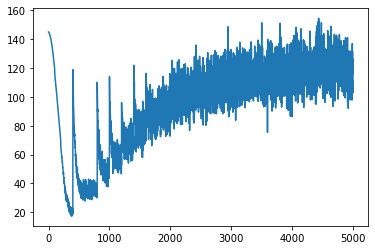

In [22]:
plt.plot(np.array(mae_liste).reshape((-1)))

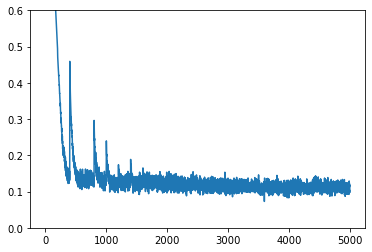

In [26]:
plt.ylim([0, 0.6])
plt.plot(-np.array(mae_liste_).reshape((-1)))

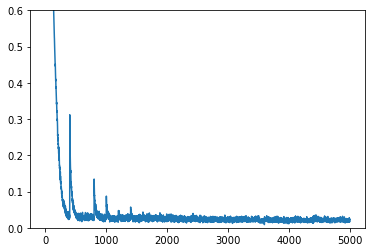

In [27]:
plt.ylim([0, 0.6])
plt.plot(np.array(loss_liste).reshape((-1)))

In [50]:
model_test = DQNet()
model_test.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = tf.keras.losses.MeanSquaredError(), metrics = 'mae')
model_test.load_weights("./target_model_monday")

In [51]:
for at in range(1, 10):
    action_0 = 0.1 * (-1 + (at - 1)//3)
    action_1 = 0.1 * (-1 + (at - 1) %3)
    print(model_test.call(inputs = tf.constant([[mini[0], mini[1], mini[2], mini[3], action_0, action_1]])).numpy()[0][0])

-639.0664
-627.7097
-616.1621
-633.0902
-621.6746
-610.07104
-627.1056
-615.6318
-603.9721


In [23]:
mini = replay_memory[0]
print(mini)

[351.0, 307.0, 119.0, 537.0, 6.0, -323.88269481403296, 351.0, 311.0]


In [38]:
for at in range(1, 10):
    action_0 = 0.1 * (-1 + (at - 1)//3)
    action_1 = 0.1 * (-1 + (at - 1) %3)
    print(model_.call(inputs = tf.constant([[mini[0], mini[1], mini[2], mini[3], action_0, action_1]])).numpy()[0][0])
print(model_.get_best([mini[0], mini[1]], [mini[2], mini[3]], get_action = True, is_training = True))

-639.0664
-627.7097
-616.1621
-633.0902
-621.6746
-610.07104
-627.1056
-615.6318
-603.9721
9


In [33]:
mini[5], mini[5] + 0.99*(model_.get_best([mini[6], mini[7]], [mini[2], mini[3]], get_action = False, is_training = True))

(-323.88269481403296, -638.1497172139352)

In [17]:
(model_test.get_best([20.0, 510.0], [203.0, 495.0], get_action = False, is_training = True), 
 model_test.get_best([20.0, 510.0], [203.0, 495.0], get_action = True, is_training = True))

(-0.5129102, 9)

In [14]:
for at in range(1, 10):
    action_0 = 0.1 * (-1 + (at - 1)//3)
    action_1 = 0.1 * (-1 + (at - 1) %3)
    print(model_test.call(inputs = tf.constant([[119.0, 537.0, 119.0, 537.0, action_0, action_1]])).numpy()[0][0])
print(model_test.get_best([119.0, 537.0], [119.0, 537.0], get_action = True, is_training = True))

-46.035507
-44.26158
-42.60855
-46.45584
-44.816727
-43.297043
-46.930946
-45.426804
-44.04123
3


In [13]:
replay_memory

[[351.0, 307.0, 119.0, 537.0, 6.0, -323.88269481403296, 351.0, 311.0],
 [351.0, 311.0, 293.0, 374.0, 5.0, -81.39410298049853, 353.0, 319.0],
 [353.0, 319.0, 351.0, 321.0, 3.0, -8.94427190999916, 347.0, 329.0],
 [347.0, 329.0, 343.0, 347.0, 8.0, -14.422205101855956, 351.0, 335.0],
 [351.0, 335.0, 351.0, 309.0, 5.0, -34.0, 351.0, 343.0],
 [351.0, 343.0, 351.0, 364.0, 1.0, -27.0, 351.0, 337.0],
 [351.0, 337.0, 335.0, 407.0, 4.0, -95.35197952848173, 351.0, 313.0],
 [351.0, 313.0, 351.0, 311.0, 9.0, -4.0, 351.0, 307.0],
 [351.0, 307.0, 187.0, 527.0, 6.0, -252.50742563338608, 351.0, 335.0],
 [351.0, 335.0, 119.0, 537.0, 5.0, -302.42354405700627, 351.0, 343.0],
 [351.0, 343.0, 218.0, 570.0, 3.0, -256.2225595063791, 351.0, 351.0],
 [351.0, 351.0, 351.0, 337.0, 6.0, -25.298221281347036, 343.0, 361.0],
 [343.0, 361.0, 100.0, 548.0, 4.0, -306.62354769325856, 343.0, 361.0],
 [343.0, 361.0, 351.0, 345.0, 2.0, -10.198039027185569, 349.0, 355.0],
 [349.0, 355.0, 281.0, 503.0, 7.0, -172.8120366178236,

In [ ]:
# acc = history.history['sparse_categorical_accuracy']
# val_acc = history.history['val_sparse_categorical_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# plt.subplot(1, 2, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.legend()

一种新的训练方法

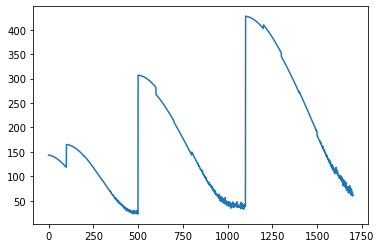

In [13]:
plt.plot(np.array(mae_list).reshape((-1)))